## Load the training data into feature matrix, class labels, and event ids:

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from expansion import *
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.display import display
from proj1_helpers import *

In [2]:
pri0_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]
pri1_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]

In [100]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
hb = pd.read_csv(DATA_TRAIN_PATH, sep=',')
pd.options.display.max_columns = None
y_orig, x_orig, _ = load_csv_data(DATA_TRAIN_PATH)
tx_orig = np.c_(x_orig, np.ones(x_orig.shape[0]).T)
hb = hb.drop(['Id'], 1)
hb.describe()

TypeError: 'CClass' object is not callable

In [4]:
t = hb[hb.DER_mass_MMC != -999].Prediction

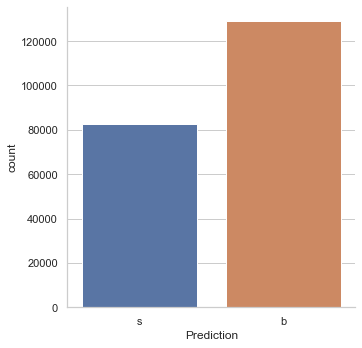

In [5]:

import seaborn as sns
sns.set(style="whitegrid")
g = sns.catplot(data=hb[hb.DER_mass_MMC != -999], x='Prediction', kind='count')


In [6]:
def cleanDataSet(dataset):
    #dataset = add_DER_mass_indicator(dataset)
    dataset_mass_def = dataset[dataset.DER_mass_MMC != -999].copy()
    dataset_mass_not_def = dataset[dataset.DER_mass_MMC == -999].copy()
    dataset_mass_not_def = dataset_mass_not_def.drop(['DER_mass_MMC'],1)
    def splitOnJetNum(dataset, DER_mass_MMC_is_defined):
        dataset = dataset.replace(-999, np.nan)
        if(DER_mass_MMC_is_defined):
            dataset = nonPolyFeatureExpansion(dataset)


        pri0 = dataset[dataset.PRI_jet_num==0].copy()
        pri0 = pri0.drop(pri0_to_drop,1)
        pri0 = pri0.drop(["PRI_jet_num","PRI_jet_all_pt"],1)

        pri1 = dataset[dataset.PRI_jet_num == 1].copy()
        pri1 = pri1.drop(pri1_to_drop,1)
        pri1 = pri1.drop(["PRI_jet_num"],1)

        pri2 = dataset[dataset.PRI_jet_num == 2].copy()
        pri2 = pri2.drop(["PRI_jet_num"],1)

        pri3 = dataset[dataset.PRI_jet_num == 3].copy()
        pri3 = pri3.drop(["PRI_jet_num"],1)

        return [pri0,pri1,pd.concat([pri2,pri3])]
    
    return splitOnJetNum(dataset_mass_def, True) + splitOnJetNum(dataset_mass_not_def, False)

In [7]:
def extractPredictions(dataset):
    return dataset.Prediction.apply(lambda x: -1 if x == 'b' else 1)

In [8]:
def add_DER_mass_indicator(data):
    data['DER_mass_MMC_present'] = (data.DER_mass_MMC == -999).apply(lambda x : 1 if x else 0)
    return data

In [9]:
def nonPolyFeatureExpansion(data):
    data['Mass_let_tau_sum_pt_ratio'] = data.DER_mass_MMC * data.DER_pt_ratio_lep_tau / (data.DER_sum_pt+1e-10)
    return data

In [10]:
def normalizeDataset(dataset):
    dataset = (dataset - dataset.mean()) / dataset.std()
    dataset = dataset.fillna(0)
    dataset = (dataset - dataset.mean()) / dataset.std()
    return dataset

In [11]:
def normalizeDataset_numpy(dataset):
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis=0)
    dataset = np.nan_to_num(dataset)
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)
    return dataset

In [12]:
def tildaNumpy(X):
    return np.c_[np.ones(X.shape[0]), X]

In [13]:
POLYNOMIAL_EXPANSION_DEGREE = 13

pri = cleanDataSet(hb)
predictions = []
pri_cross_validation_test = []
prediction_cross_validation_test = []

In [14]:
pri[1]

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_all_pt,Mass_let_tau_sum_pt_ratio
1,b,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,46.226,0.725,1.158,46.226,1.130289
7,s,154.916,10.418,94.714,29.169,2.897,1.526,138.178,0.365,-1.305,78.800,0.654,1.547,28.740,0.506,-1.347,22.275,-1.761,187.299,30.638,-0.715,-1.724,30.638,0.409214
9,s,128.053,88.941,69.272,193.392,1.609,28.859,255.123,0.599,0.538,54.646,-1.533,0.416,32.742,-0.317,-0.636,132.678,0.845,294.741,167.735,-2.767,-2.514,167.735,0.300654
12,b,145.297,64.234,103.565,106.999,2.183,24.660,192.245,0.576,0.689,62.890,-0.766,-1.632,36.237,0.722,-0.035,43.910,-1.907,232.362,93.117,-0.970,1.943,93.117,0.435335
16,b,114.256,4.351,67.963,47.221,2.954,26.243,100.930,1.145,0.218,30.145,0.484,-0.929,34.522,-0.215,1.941,41.899,2.055,191.568,36.263,-0.766,-0.686,36.263,1.296177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249981,b,87.390,0.299,40.546,244.825,0.760,30.181,347.795,0.728,1.017,61.251,-0.816,-2.326,44.618,-1.542,-2.548,140.054,-2.544,449.589,241.926,-1.621,0.528,241.926,0.182924
249987,b,140.080,29.729,83.393,7.918,2.673,38.975,133.039,0.370,-1.347,70.410,-1.732,-2.851,26.085,-1.769,-0.178,47.083,0.698,185.743,36.544,-2.644,1.017,36.544,0.389582
249988,b,89.509,86.277,79.870,56.636,1.709,23.499,154.023,0.885,-0.800,49.055,-1.040,0.142,43.415,0.216,-1.016,43.221,1.944,175.444,61.554,-2.851,2.933,61.554,0.514309
249991,s,133.457,77.540,88.989,69.650,2.484,2.490,166.396,0.629,-0.084,58.596,-0.834,-0.711,36.831,-1.172,1.749,41.870,-1.073,203.174,70.969,-1.234,2.521,70.969,0.504486


In [15]:
for idx, dataset in enumerate(pri):
    predictions.append(extractPredictions(dataset))
    dataset = dataset.drop(['Prediction'],1)
    pri[idx] = tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE)))
;

''

In [16]:
def score(X, w, y):
    return (y == predict_labels(w,X)).sum()/len(y)

## Do your thing crazy machine learning thing here :) ...

In [17]:
def compute_e(y, tx, w):
    return y - tx @ w

def compute_loss_MSE(n2, e):
    return (e.T @ e) / n2
    
def compute_gradient_MSE(tx, n, e):
    return - tx.T @ e / n

def compute_loss_MAE(n, e):
    return 1/n * np.sum(np.abs(e))
    
def compute_gradient_MAE(tx, n, e):
    return -1/n*tx.T @ np.sign(e)

def compute_loss_rmse(n2, e):
    return np.sqrt(2 * compute_loss_MSE(n2, e))

In [18]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using gradient descent.
    Uses MSE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    
    
    loss = 0
    w = initial_w
    n = y.shape[0]
    n2 = n*2
    
    for n_iter in range(max_iters):
        e = compute_e(y, tx, w)
        gradient = compute_gradient_MSE(tx, n, e)
        loss = compute_loss_MSE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))

    return w, loss

In [21]:
'''
weights = np.array([])
for i in range(100):
    initial_w = np.full(tX.shape[1], i/100)
    max_iters = 100
    gamma = 0.3
    w, loss = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    weights = np.append(weights, loss)
idx = np.argmin(weights)
'''
initial_w = np.zeros(pri[0].shape[1])
max_iters = 1000
gamma = 0.001
w, loss = least_squares_GD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

0.3130589853338476


In [22]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using gradient descent.
    Uses MAE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    loss = 0
    w = initial_w
    n = y.shape[0]
    n2 = n*2
    
    for n_iter in range(max_iters):
        e = compute_e(y, tx, w)
        gradient = compute_gradient_MAE(tx, n, e)
        loss = compute_loss_MAE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))

    return w, loss

In [23]:
initial_w = np.zeros(pri[0].shape[1])
max_iters = 1000
gamma = 0.3
w, loss = least_squares_GD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

0.5287996461931668


In [24]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using stochastic gradient descent.
    Uses MSE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    loss = 0
    w = initial_w[:, np.newaxis]
    n = y.shape[0]
    n2 = n*2
    data_size = len(y)
    shuffled_indices = np.random.permutation(np.arange(data_size))
    shuffled_y = y[shuffled_indices]
    shuffled_tx = tx[shuffled_indices]
    shuffled_y = shuffled_y[:,np.newaxis]
    for n_iter, by, btx in zip(range(max_iters), shuffled_y, shuffled_tx):
        by = by[np.newaxis]
        btx = btx[np.newaxis, :]
        e = compute_e(by, btx, w)
        gradient = compute_gradient_MSE(btx, n, e)
        loss = compute_loss_MSE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))
    return w, compute_loss_MSE(n2, compute_e(y, tx, w[:,0]))

In [29]:
initial_w = np.full(pri[0].shape[1], 0.1)
max_iters = 100000
gamma = 0.000000001
w, loss = least_squares_SGD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

nan


In [30]:
def least_squares(y, tx):
    """
    Linear regression using normal equations.
    Use MSE loss function
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """    
    
    w = la.solve(tx.T @ tx, tx.T @ y)
    
    return w, compute_loss_MSE(y.shape[0]*2, compute_e(y, tx, w))

In [31]:
w, loss = least_squares(predictions[0], pri[0])
print(loss)

0.2720999044174108


# Ridge regression
with cross-validation

In [18]:
def ridge_regression(y, tx, lambda_):
    """
    Ridge regression using normal equations.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """ 
     
    X = tx.T @ tx
    n = y.shape[0]
    w = la.solve(X + lambda_ * (2 * n) * np.eye(X.shape[0]), tx.T @ y)
    return w, compute_loss_rmse(2 * n, compute_e(y, tx, w))

In [19]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # split the data based on the given ratio
    # ***************************************************
    N = x.shape[0]
    indices_training = np.random.choice(N, (int)(ratio*N),replace=False)
    mask_training = np.zeros(N, dtype=bool)
    mask_training[indices_training] = True
    mask_testing = ~mask_training
    return (x[mask_training], x[mask_testing], y[mask_training], y[mask_testing])

In [20]:
from plots import *
def ridge_regression_cross(x, y, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 60)
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_train, x_test, y_train, y_test = split_data(x,y, ratio, seed)
    
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # ridge regression with a given lambda
        # ***************************************************
        weights, rmse = ridge_regression(y_train, x_train, lambda_)
        rmse_tr.append(rmse)
        rmse_te.append(compute_loss_rmse(y_test.shape[0]*2, compute_e(y_test,x_test, weights)))

        print("proportion={p}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas)
        

proportion=0.8, lambda=0.000, Training RMSE=0.508, Testing RMSE=0.635
proportion=0.8, lambda=0.000, Training RMSE=0.509, Testing RMSE=0.658
proportion=0.8, lambda=0.000, Training RMSE=0.509, Testing RMSE=0.680
proportion=0.8, lambda=0.000, Training RMSE=0.509, Testing RMSE=0.696
proportion=0.8, lambda=0.000, Training RMSE=0.510, Testing RMSE=0.703
proportion=0.8, lambda=0.000, Training RMSE=0.510, Testing RMSE=0.701
proportion=0.8, lambda=0.000, Training RMSE=0.511, Testing RMSE=0.691
proportion=0.8, lambda=0.000, Training RMSE=0.511, Testing RMSE=0.673
proportion=0.8, lambda=0.000, Training RMSE=0.511, Testing RMSE=0.653
proportion=0.8, lambda=0.000, Training RMSE=0.512, Testing RMSE=0.630
proportion=0.8, lambda=0.000, Training RMSE=0.512, Testing RMSE=0.609
proportion=0.8, lambda=0.000, Training RMSE=0.512, Testing RMSE=0.591
proportion=0.8, lambda=0.000, Training RMSE=0.513, Testing RMSE=0.577
proportion=0.8, lambda=0.000, Training RMSE=0.513, Testing RMSE=0.568
proportion=0.8, lamb

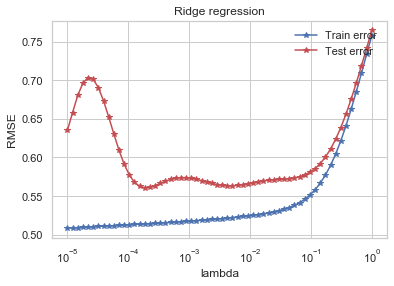

In [21]:
%%time
ridge_regression_cross(pri[5], predictions[5], 0.8, 0)

In [22]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [27]:
def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""

    x_tr = np.delete(x, k_indices[k], axis=0)
    y_tr = np.delete(y, k_indices[k], axis=0)
    
    x_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    w, rmse = ridge_regression(y_tr, x_tr, lambda_)
    
    n = y.shape[0]
    loss_tr = rmse
    loss_te = compute_loss_rmse(2*n , compute_e(y_te, x_te, w))
    return loss_tr, loss_te

In [104]:
%%time

def cross_validation_visualization_wo_error(lambdas, rmse_tr, rmse_te):
    zeros = np.zeros(len(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, zeros, zeros)

ridge_parameters = []
    
def cross_validation_demo(i):
    seed = 2019
    k_fold = 2
    lambdas = np.logspace(-10, -3, 15)
    if i == 0:
        lambdas = np.logspace(-3.5, -1.5, 15)
    elif i == 1:
        lambdas = np.logspace(-6, -3, 15)
    elif i == 2:
        lambdas = np.logspace(-7, -5, 15)
    elif i == 3:
        lambdas = np.logspace(-3, -2, 15)
    
    y = predictions[i]
    y = y[:,np.newaxis]
    x = pri[i]
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    
    for lambda_ in lambdas:
        loss_tr = []
        loss_te = []
        for k in range(k_fold):
            tr, te = cross_validation(y, x, k_indices, k, lambda_)
            loss_tr.append(tr)
            loss_te.append(te)
        rmse_tr.append(np.mean(loss_tr))
        rmse_te.append(np.mean(loss_te))
        var_tr.append(np.std(loss_tr))
        var_te.append(np.std(loss_te))
    optimal = lambdas[np.argmin(var_te)]
    print(optimal)
    ridge_parameters.append(optimal)
    plt.subplot(2, 4, 1+i)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, var_tr, var_te)

for i in range(len(pri)):
    cross_validation_demo(i)

NameError: name 'build_k_indices' is not defined

In [211]:
w_pri = []
for i in range(len(pri)):
    w, loss = ridge_regression(predictions[i], pri[i], ridge_parameters[i])
    print(loss)
    w_pri.append(w)

0.7575175948028048
0.8069999111160885
0.7647957383995958
0.41754322045820225
0.5128168808156555
0.5190484670966447


# Logistic regression

In [101]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1/(1 + np.exp(-t))
    
def compute_loss_logistic(y, tx, w):
    """compute the cost by negative log likelihood."""
    return np.sum(np.log(1 + np.exp(tx @ w)) - y * (tx @ w))


def compute_gradient_logistic(y, tx, w):
    """compute the gradient of loss."""
    return tx.T @ (sigmoid(tx @ w) - y)


def logistic_regression_step(y, tx, w):
    """return the loss, gradient"""
    return compute_loss_logistic(y, tx, w), compute_gradient_logistic(y, tx, w)
  

In [102]:
# TODO
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    """
    Logistic regression using gradient descent or SGD.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """  
    def learning_by_gradient_descent(y, tx, w, gamma):
        """
        Do one step of gradient descen using logistic regression.
        Return the loss and the updated w.
        """
        loss, gradient = logistic_regression_step(y, tx, w)
        w -= gamma * gradient
        return loss, w
    
    # init parameters
    threshold = 1e-8
    losses = []
    w = initial_w

    # build tx
    y = y[:,np.newaxis]

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
     
    print("loss={l}".format(l=compute_loss_logistic(y, tx, w)))
    return w, losses[-1]
    

In [103]:
y = (y+1)/2
gamma = 1e-6
initial_w = np.zeros((pri[0].shape[1], 1))
w, loss = logistic_regression(predictions[0], pri[0], initial_w, 10000, gamma)

Current iteration=0, loss=51145.85466827621
Current iteration=100, loss=34890.484787313915
Current iteration=200, loss=33641.276577518096
Current iteration=300, loss=33160.07729551468
Current iteration=400, loss=32871.834328063065
Current iteration=500, loss=32668.43163422678
Current iteration=600, loss=32513.35417963414
Current iteration=700, loss=32389.443607726047
Current iteration=800, loss=32287.30450649813
Current iteration=900, loss=32201.333556455655
Current iteration=1000, loss=32127.62579606862
Current iteration=1100, loss=32063.393896175483
Current iteration=1200, loss=32006.571959982197
Current iteration=1300, loss=31955.64628308703
Current iteration=1400, loss=31909.478357822576
Current iteration=1500, loss=31867.221898433403
Current iteration=1600, loss=31828.265342017068
Current iteration=1700, loss=31792.153742643415
Current iteration=1800, loss=31758.52572073961
Current iteration=1900, loss=31727.085511825324
Current iteration=2000, loss=31697.59520920833
Current itera

KeyboardInterrupt: 

In [86]:
# TODO
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """
    Regularized logistic regression using gradient descent or SGD.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """    
    def penalized_logistic_regression(y, tx, w, lambda_):
        """return the loss, gradient"""
        loss, gradient = logistic_regression_step(y, tx, w)
        loss     += 2 * lambda_ * la.norm(w)**2
        gradient += lambda_ * w

        return loss, gradient
    
    def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
        """
        Do one step of gradient descent, using the penalized logistic regression.
        Return the loss and updated w.
        """
        loss, gradient = penalized_logistic_regression(y, tx, w, lambda_) 
        w = w - gamma * gradient 

        return loss, w
    
    # init parameters
    threshold = 1e-8
    losses = []
    y = (y+1)/2

    w = initial_w
    y = y[:,np.newaxis]

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
            
    print("loss={l}".format(l=compute_loss_logistic(y, tx, w)))
    

In [96]:
lambda_ = 1e-6
initial_w = np.zeros((pri[0].shape[1], 1))
max_iters = 10000
gamma = 2e-6
w, loss = reg_logistic_regression(predictions[0], pri[0], lambda_, initial_w, max_iters, gamma)
print(np.mean(predict_labels(w, )))

Current iteration=0, loss=51145.85466827621
Current iteration=100, loss=33636.426693549955
Current iteration=200, loss=32870.27952016065
Current iteration=300, loss=32512.507258851587
Current iteration=400, loss=32286.76557299292
Current iteration=500, loss=32127.25374746054
Current iteration=600, loss=32006.307502541622
Current iteration=700, loss=31909.287365296554
Current iteration=800, loss=31828.124079379344
Current iteration=900, loss=31758.418396475445
Current iteration=1000, loss=31697.511949064083
Current iteration=1100, loss=31643.756531721217
Current iteration=1200, loss=31596.382040636454
Current iteration=1300, loss=31554.551651151007
Current iteration=1400, loss=31517.42993651121
Current iteration=1500, loss=31484.290265979995
Current iteration=1600, loss=31454.49627434351
Current iteration=1700, loss=31427.521782967
Current iteration=1800, loss=31402.941950477332
Current iteration=1900, loss=31380.415532359075
Current iteration=2000, loss=31359.666895786737
Current itera

KeyboardInterrupt: 

## End of ML magic

In [149]:
initial_w = np.full(pri[0].shape[1], 0.1)
max_iters = 600
gamma = 0.0001
w, loss = least_squares_GD(predictions[0].to_numpy(), pri[0], initial_w, max_iters, gamma)
print(loss)

NameError: name 'least_squares_GD' is not defined

In [150]:
# methodes element of this contains [(methode_for_learning,(parameters_of_methode))]
'''pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]
'''
'''
lamb = 4.64e-06
pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
'''
pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]


def learn(pri, pri_learn_func):
    w_pri = []
    losses = []
    for idx in range(len(pri)):
        learning_function, parameters = pri_learn_func[idx]
        w ,loss = learning_function(predictions[idx].to_numpy(),pri[idx],*parameters)
        print("* " + str(idx) + " loss : " + str(loss))
        w_pri.append(w)
        losses.append(loss)
    return (w_pri, losses)

NameError: name 'least_squares_GD' is not defined

In [ ]:
w_pri, losses = learn(pri,pri_learn_func)

In [ ]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [ ]:
len(w_pri[0])

In [ ]:
def score_attempt(pri_cross_validation_test, w_pri, prediction_cross_validation_test):
    res = []
    for i in range(len(w_pri)):
        s = score(pri_cross_validation_test[i], w_pri[i], prediction_cross_validation_test[i])
        res.append(s)
        print("Socre for pri : " +  str(i) + " is : "+ str(s))
    return res

In [ ]:
score_attempt(pri_cross_validation_test, w_pri, prediction_cross_validation_test)

In [ ]:
score(pri_cross_validation_test[1], w_pri[1], prediction_cross_validation_test[1]).mean()

In [ ]:
loss_mean = []
for i in tqdm(range(0, 1000, 2)):
    lamb = i/1000
    pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
    w_pri, losses = learn(pri,pri_learn_func)
    loss_mean.append(np.mean(losses))

In [ ]:
loss_mean.index(np.min(loss_mean))

In [ ]:
 w_pri =w_pri_deg4

In [ ]:
test = (1,2)

In [ ]:
def p(t,_):
    print(_)

p(*test)

## Generate predictions and save ouput in csv format for submission:

In [212]:
DATA_TEST_PATH = '../data/test.csv'
hbt = pd.read_csv(DATA_TEST_PATH, sep=',')

hbt = hbt.drop(['Prediction'], 1)

hbt = hbt.set_index(['Id'])

In [213]:
test_pri = cleanDataSet(hbt)
test_pri_tX = [] # tX arrays to run prediction on
for idx , dataset in enumerate(test_pri):
    test_pri_tX.append( tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE))))

In [214]:
def predict(test_pri,test_pri_tX, w_pri):
    for idx, dataset in enumerate(test_pri_tX):
        test_pri[idx]['Prediction'] = predict_labels(w_pri[idx],dataset)
    return test_pri

In [215]:
test_prediction = predict(test_pri,test_pri_tX,w_pri)

In [216]:
test_prediction = pd.concat(test_prediction,sort=True)

In [217]:
test_prediction = test_prediction.sort_index()

In [218]:
OUTPUT_PATH = 'predictions.csv'
create_csv_submission(test_prediction.Prediction.keys(), test_prediction.Prediction.values, OUTPUT_PATH)

------------------

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)
hbt = pd.read_csv(DATA_TEST_PATH, sep=',')
hbt = hbt.drop(['Id', 'Prediction'], 1)
hbt = hbt.replace(-999, np.nan)
hbt = (hbt - hbt.mean()) / hbt.std()
hbt = hbt.fillna(0)
hbt = (hbt - hbt.mean()) / hbt.std()
tX_test = np.c_[np.ones(X_test.shape[0]), hbt.to_numpy()]

In [ ]:
OUTPUT_PATH = 'predictions.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w[1:], tX_test)#[:, [0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]) # Selected desired columns
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [71]:
print(len(test_prediction.Prediction.values))
print(len(test_prediction.Prediction.values[test_prediction.Prediction.values > 0]))

568238
173231


# Submissions scores
Best score by technique

<ul>
    <li>MSE, gradient descent : 0.649</li>
    <li>MAE, gradient descent : 0.678 </li>
    <li>ridge regression      : 0.664</li>
</ul>
Best score after not being stupid with bias:

* MSE, GD: 
* MAE, GD: 0.639
* LSQ: 0.706
* R-REG: 0.730

Best score after normalizing test set + putting zero where unknown:

* LSQ: 0.747
* R-REG: 0.745

Feature expansion?

Degree polynomial 4, and jet-num separation MAE
with these learning parameters:
```
pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]
```
0.801


Degree polynomial 9 , jet-num separation
learning parameters:
```
lamb = 4.64e-06
pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
```
0.779

With r-regression and cross-validation, 12 degrees:

- 0.81
- With Jeremy's hack (1 more dimension for NaN mass): 0.811
- Taking whole dataset, not 90%: 0.807

Split the dataset into 8. With and without DM mass defined.
- 0.812

Split data PRI 0, 1, 2+3 and my Mass deffined
- 0.814